In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from time import sleep
from IPython.display import clear_output
from math import ceil,floor
 
%matplotlib inline

** La clase Agente**

Dentro de la clase Agente encontraremos la tabla donde iremos almacenando las políticas. En nuestro caso la tabla cuenta de 3 coordenadas:

1. La posición actual del jugador.
2. La posición “y” de la pelota.
3. La posición en el eje “x” de la pelota.
4. 
Además en esta clase, definiremos el factor de descuento, el learning rate y el ratio de exploración.

Los métodos más importantes:

- get_next_step() decide la siguiente acción a tomar en base al ratio de exploración si tomar “el mejor paso” que tuviéramos almacenado ó tomar un paso al azar, dando posibilidad a explorar el ambiente
- update() aquí se actualizan las políticas mediante la ecuación de Bellman que vimos anteriormente. Es su implementación en python.

In [2]:
class PongAgent:
    
    def __init__(self, game, policy=None, discount_factor = 0.1, learning_rate = 0.1, ratio_explotacion = 0.9):
 
        # Creamos la tabla de politicas
        if policy is not None:
            self._q_table = policy
        else:
            position = list(game.positions_space.shape)
            position.append(len(game.action_space))
            self._q_table = np.zeros(position)
        
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.ratio_explotacion = ratio_explotacion
 
    def get_next_step(self, state, game):
        
        # Damos un paso aleatorio...
        next_step = np.random.choice(list(game.action_space))
        
        # o tomaremos el mejor paso...
        if np.random.uniform() <= self.ratio_explotacion:
            # tomar el maximo
            idx_action = np.random.choice(np.flatnonzero(
                    self._q_table[state[0],state[1],state[2]] == self._q_table[state[0],state[1],state[2]].max()
                ))
            next_step = list(game.action_space)[idx_action]
 
        return next_step
 
    # actualizamos las politicas con las recompensas obtenidas
    def update(self, game, old_state, action_taken, reward_action_taken, new_state, reached_end):
        idx_action_taken =list(game.action_space).index(action_taken)
 
        actual_q_value_options = self._q_table[old_state[0], old_state[1], old_state[2]]
        actual_q_value = actual_q_value_options[idx_action_taken]
 
        future_q_value_options = self._q_table[new_state[0], new_state[1], new_state[2]]
        future_max_q_value = reward_action_taken  +  self.discount_factor*future_q_value_options.max()
        if reached_end:
            future_max_q_value = reward_action_taken #maximum reward
 
        self._q_table[old_state[0], old_state[1], old_state[2], idx_action_taken] = actual_q_value + \
                                              self.learning_rate*(future_max_q_value -actual_q_value)
    
    def print_policy(self):
        for row in np.round(self._q_table,1):
            for column in row:
                print('[', end='')
                for value in column:
                    print(str(value).zfill(5), end=' ')
                print('] ', end='')
            print('')
            
    def get_policy(self):
        return self._q_table

**La clase Environment**

En la clase de Ambiente encontramos implementada la lógica y control del juego del pong. Se controla que la pelotita rebote, que no se salga de la pantalla y se encuentran los métodos para graficar y animar en matplotlib.

Por Defecto se define una pantalla de 40 pixeles x 50px de alto y si utilizamos la variable “movimiento_px = 5” nos quedará definida nuestra tabla de políticas en 8 de alto y 10 de ancho (por hacer 40/5=8 y 50/5=10). Estos valores se pueden modificar a gusto!

Además, muy importante, tenemos el control de cuándo dar las recompensas y penalizaciones, al perder cada vida y detectar si el juego a terminado

In [3]:
class PongEnvironment:
    
    def __init__(self, max_life=3, height_px = 40, width_px = 50, movimiento_px = 3):
        
        self.action_space = ['Arriba','Abajo']
        
        self._step_penalization = 0
        
        self.state = [0,0,0]
        
        self.total_reward = 0
        
        self.dx = movimiento_px
        self.dy = movimiento_px
        
        filas = ceil(height_px/movimiento_px)
        columnas = ceil(width_px/movimiento_px)
        
        self.positions_space = np.array([[[0 for z in range(columnas)] 
                                                  for y in range(filas)] 
                                                     for x in range(filas)])
 
        self.lives = max_life
        self.max_life=max_life
        
        self.x = randint(int(width_px/2), width_px) 
        self.y = randint(0, height_px-10)
        
        self.player_alto = int(height_px/4)
 
        self.player1 = self.player_alto  # posic. inicial del player
        
        self.score = 0
        
        self.width_px = width_px
        self.height_px = height_px
        self.radio = 2.5
 
    def reset(self):
        self.total_reward = 0
        self.state = [0,0,0]
        self.lives = self.max_life
        self.score = 0
        self.x = randint(int(self.width_px/2), self.width_px) 
        self.y = randint(0, self.height_px-10)
        return self.state
 
    def step(self, action, animate=False):
        self._apply_action(action, animate)
        done = self.lives <=0 # final
        reward = self.score
        reward += self._step_penalization
        self.total_reward += reward
        return self.state, reward , done
 
    def _apply_action(self, action, animate=False):
        
        if action == "Arriba":
            self.player1 += abs(self.dy)
        elif action == "Abajo":
            self.player1 -= abs(self.dy)
            
        self.avanza_player()
 
        self.avanza_frame()
 
        if animate:
            clear_output(wait=True);
            fig = self.dibujar_frame()
            plt.show()
 
        self.state = (floor(self.player1/abs(self.dy))-2, floor(self.y/abs(self.dy))-2, floor(self.x/abs(self.dx))-2)
    
    def detectaColision(self, ball_y, player_y):
        if (player_y+self.player_alto >= (ball_y-self.radio)) and (player_y <= (ball_y+self.radio)):
            return True
        else:
            return False
    
    def avanza_player(self):
        if self.player1 + self.player_alto >= self.height_px:
            self.player1 = self.height_px - self.player_alto
        elif self.player1 <= -abs(self.dy):
            self.player1 = -abs(self.dy)
 
    def avanza_frame(self):
        self.x += self.dx
        self.y += self.dy
        if self.x <= 3 or self.x > self.width_px:
            self.dx = -self.dx
            if self.x <= 3:
                ret = self.detectaColision(self.y, self.player1)
 
                if ret:
                    self.score = 10
                else:
                    self.score = -10
                    self.lives -= 1
                    if self.lives>0:
                        self.x = randint(int(self.width_px/2), self.width_px)
                        self.y = randint(0, self.height_px-10)
                        self.dx = abs(self.dx)
                        self.dy = abs(self.dy)
        else:
            self.score = 0
 
        if self.y < 0 or self.y > self.height_px:
            self.dy = -self.dy
 
    def dibujar_frame(self):
        fig = plt.figure(figsize=(5, 4))
        a1 = plt.gca()
        circle = plt.Circle((self.x, self.y), self.radio, fc='slategray', ec="black")
        a1.set_ylim(-5, self.height_px+5)
        a1.set_xlim(-5, self.width_px+5)
 
        rectangle = plt.Rectangle((-5, self.player1), 5, self.player_alto, fc='gold', ec="none")
        a1.add_patch(circle);
        a1.add_patch(rectangle)
        #a1.set_yticklabels([]);a1.set_xticklabels([]);
        plt.text(4, self.height_px, "SCORE:"+str(self.total_reward)+"  LIFE:"+str(self.lives), fontsize=12)
        if self.lives <=0:
            plt.text(10, self.height_px-14, "GAME OVER", fontsize=16)
        elif self.total_reward >= 1000:
            plt.text(10, self.height_px-14, "YOU WIN!", fontsize=16)
        return fig

**El juego: Simular miles de veces para enseñar**

Finalmente definimos una función para jugar, donde indicamos la cantidad de veces que queremos iterar la simulación del juego e iremos almacenando algunas estadísticas sobre el comportamiento del agente, si mejora el puntaje con las iteraciones y el máximo puntaje alcanzado.

In [4]:
def play(rounds=5000, max_life=3, discount_factor = 0.1, learning_rate = 0.1,
         ratio_explotacion=0.9,learner=None, game=None, animate=False):
 
    if game is None:
        game = PongEnvironment(max_life=max_life, movimiento_px = 3)
        
    if learner is None:
        print("Begin new Train!")
        learner = PongAgent(game, discount_factor = discount_factor,learning_rate = learning_rate, ratio_explotacion= ratio_explotacion)
 
    max_points= -9999
    first_max_reached = 0
    total_rw=0
    steps=[]
 
    for played_games in range(0, rounds):
        state = game.reset()
        reward, done = None, None
        
        itera=0
        while (done != True) and (itera < 3000 and game.total_reward<=1000):
            old_state = np.array(state)
            next_action = learner.get_next_step(state, game)
            state, reward, done = game.step(next_action, animate=animate)
            if rounds > 1:
                learner.update(game, old_state, next_action, reward, state, done)
            itera+=1
        
        steps.append(itera)
        
        total_rw+=game.total_reward
        if game.total_reward > max_points:
            max_points=game.total_reward
            first_max_reached = played_games
        
        if played_games %500==0 and played_games >1 and not animate:
            print("-- Partidas[", played_games, "] Avg.Puntos[", int(total_rw/played_games),"]  AVG Steps[", int(np.array(steps).mean()), "] Max Score[", max_points,"]")
                
    if played_games>1:
        print('Partidas[',played_games,'] Avg.Puntos[',int(total_rw/played_games),'] Max score[', max_points,'] en partida[',first_max_reached,']')
        
    #learner.print_policy()
    
    return learner, game

Para entrenar ejecutamos la función con los siguientes parámetros:

- 6000 partidas jugará
- ratio de explotación: el 85% de las veces será avaro, pero el 15% elige acciones aleatorias, dando lugar a la exploración.
- learning rate = se suele dejar en el 10 por ciento como un valor razonable, dando lugar a las recompensas y permitiendo actualizar la importancia de cada acción poco a poco. Tras más iteraciones, mayor importancia tendrá esa acción.
- discount_factor = También se suele empezar con valor de 0.1 pero aquí utilizamos un valor del 0.2 para intentar indicar al algoritmo que nos interesa las recompensas a más largo plazo.

In [5]:
learner, game = play(rounds=6000, discount_factor = 0.2, learning_rate = 0.1, ratio_explotacion=0.85)

Begin new Train!
-- Partidas[ 500 ] Avg.Puntos[ 14 ]  AVG Steps[ 219 ] Max Score[ 140 ]
-- Partidas[ 1000 ] Avg.Puntos[ 21 ]  AVG Steps[ 244 ] Max Score[ 150 ]
-- Partidas[ 1500 ] Avg.Puntos[ 22 ]  AVG Steps[ 245 ] Max Score[ 150 ]
-- Partidas[ 2000 ] Avg.Puntos[ 23 ]  AVG Steps[ 248 ] Max Score[ 160 ]
-- Partidas[ 2500 ] Avg.Puntos[ 25 ]  AVG Steps[ 256 ] Max Score[ 290 ]
-- Partidas[ 3000 ] Avg.Puntos[ 28 ]  AVG Steps[ 267 ] Max Score[ 350 ]
-- Partidas[ 3500 ] Avg.Puntos[ 30 ]  AVG Steps[ 274 ] Max Score[ 350 ]
-- Partidas[ 4000 ] Avg.Puntos[ 32 ]  AVG Steps[ 279 ] Max Score[ 350 ]
-- Partidas[ 4500 ] Avg.Puntos[ 32 ]  AVG Steps[ 279 ] Max Score[ 350 ]
-- Partidas[ 5000 ] Avg.Puntos[ 33 ]  AVG Steps[ 282 ] Max Score[ 350 ]
-- Partidas[ 5500 ] Avg.Puntos[ 33 ]  AVG Steps[ 284 ] Max Score[ 390 ]
Partidas[ 5999 ] Avg.Puntos[ 34 ] Max score[ 390 ] en partida[ 5036 ]


En las salidas vemos sobre todo cómo va mejorando en la cantidad de “steps” que da el agente antes de perder la partida.

**Veamos el resultado!**

Ya contamos con nuestro agente entrenado, ahora veamos qué tal se comporta en una partida de pong, y lo podemos ver jugar, pasando el parámetro animate=True.

Antes de jugar, instanciamos un nuevo agente “learner2” que utilizará las políticas que creamos anteriormente. A este agente le seteamos el valor de explotación en 1, para evitar que tome pasos aleatorios.

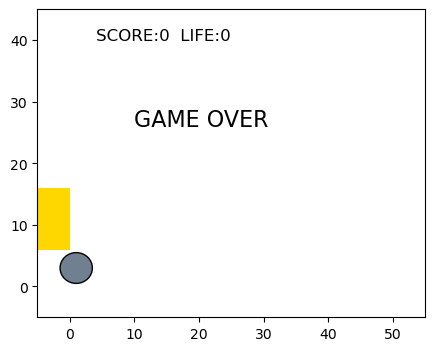

In [6]:
learner2 = PongAgent(game, policy=learner.get_policy())
learner2.ratio_explotacion = 1.0  # con esto quitamos las elecciones aleatorias al jugar
player = play(rounds=1, learner=learner2, game=game, animate=True)